# Predição de links por métodos clássicos
Neste notebook exploramos a predição de links na base de dados de disciplinas dos alunos por meio de métodos clássicos.

In [1]:
from data_processing import load_student_data, get_optativas
dados = load_student_data()

dados['formados']

,ID_ANONIMO,CR,PERIODO,INGRESSO,CODIGO,ANO,PERIODO.1,NOTA,CH,SITUACAOALUNO
0,13236,0.6826,10,12/07/07,IF68E,2012,1,8.2,60,Formado
1,13236,0.6826,10,12/07/07,IF35J,2007,2,7.0,60,Formado
2,13236,0.6826,10,12/07/07,MA33K,2007,2,0.0,60,Formado
3,13236,0.6826,10,12/07/07,F2D070,2007,2,8.8,75,Formado
4,13236,0.6826,10,12/07/07,E1D000,2007,2,0.0,30,Formado
...,...,...,...,...,...,...,...,...,...,...
30139,202261,0.9013,10,05/03/18,EEE32,2021,1,7.7,60,Formado
30140,202261,0.9013,10,05/03/18,CSR31,2020,2,8.5,30,Formado
30141,202261,0.9013,10,05/03/18,CSR31,2020,1,-1.0,30,Formado
30142,202261,0.9013,10,05/03/18,EEQ31,2019,2,9.4,75,Formado


In [68]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_data_all(tipo_aluno : str):
    return dados[tipo_aluno]

def get_data_split_bystudent(test_size : float, tipo_aluno : str):
    _data = np.random.choice(dados[tipo_aluno].ID_ANONIMO.unique(), size=int(len(dados[tipo_aluno].ID_ANONIMO.unique())*test_size))
    data = dados[tipo_aluno][dados[tipo_aluno]["ID_ANONIMO"].isin(_data)]
    return data

def get_data_split_all(tipo_aluno : str, test_size=float):
    return np.random.choice(dados[tipo_aluno], size=int(len(dados[tipo_aluno])*test_size))

def create_graph(data, disciplinas):
    G = nx.Graph()

    #print(data.ID_ANONIMO.unique())

    #G.add_nodes_from(disciplinas)
    G.add_nodes_from(data.ID_ANONIMO.unique())

    attrs = {id: {'ingresso': data[data['ID_ANONIMO'] == id]['INGRESSO'].values[0],
                'cr': data[data['ID_ANONIMO'] == id]['CR'].values[0],
                'situacao': data[data['ID_ANONIMO'] == id]['SITUACAOALUNO'].values[0],
                'aluno': 1} for id in data.ID_ANONIMO.unique()}
    nx.set_node_attributes(G, attrs)

    attrs = {id: {'ch': data[data['CODIGO'] == id]['CH'].values[0],
                'aluno': 0} for id in data.CODIGO.unique()}
    nx.set_node_attributes(G, attrs)

    for x in data.values:
        x[7] = float(str(x[7]).replace(',','.'))
        if(x[7] != x[7] or x[7] <= 0):
            x[7] = 0.01
        if(x[4] in disciplinas):
            G.add_node(x[4])
            G.add_edge(x[0], x[4], weight=1/x[7])

    return G

subset = get_data_split_bystudent(0.01,'formados')
disciplinas = get_optativas()
G = create_graph(subset, disciplinas)

In [64]:
subset.describe()

,ID_ANONIMO,CR,PERIODO,ANO,PERIODO.1,NOTA,CH
count,232.000000,232.000000,232.0,232.000000,232.000000,232.000000,232.000000
mean,113212.827586,0.586917,10.0,2013.474138,1.508621,6.165948,60.646552
std,3378.783480,0.018379,0.0,2.359328,0.501007,2.537853,36.148624
min,109723.000000,0.569200,10.0,2009.000000,1.000000,0.000000,30.000000
25%,109723.000000,0.569200,10.0,2012.000000,1.000000,5.000000,45.000000
50%,116470.000000,0.569200,10.0,2014.000000,2.000000,6.600000,60.000000
75%,116470.000000,0.605900,10.0,2015.000000,2.000000,8.000000,60.000000
max,116470.000000,0.605900,10.0,2018.000000,2.000000,10.000000,360.000000


In [65]:
subset.describe(include=[object])

,INGRESSO,CODIGO,SITUACAOALUNO
count,232,232,232
unique,2,99,1
top,01/03/10,MA62A,Formado
freq,120,7,232


In [19]:
centrality = nx.degree_centrality(G)

centrality = sorted(centrality.items(), key=lambda item: -item[1])

#print("Degree centrality: ", centrality)

In [20]:
path = nx.shortest_path(G, source=202266, target=202701, weight="weight")
length = nx.shortest_path_length(G, source=202266, target = 202701, weight="weight")

print(f"Shortest path: {path}, Length: {length}")

NodeNotFound: Either source 202266 or target 202701 is not in G

In [ ]:
from networkx.algorithms import community
from collections import defaultdict
communities = list(community.louvain_communities(G))

with open('comunidades.txt', 'w') as f:
    for x in communities:
        aluno_list = []
        disc_list = []
        ing_dict = defaultdict(int)
        status_dict = defaultdict(int)
        for y in x:
            if str(y).__contains__('.'):
                aluno_list.append(y)
            else:
                disc_list.append(y)
        if(disc_list.__len__() > 1):
            for x in aluno_list:
                ing_dict[(nx.get_node_attributes(G, 'ingresso')[x].split('/')[2])] += 1
                status_dict[(nx.get_node_attributes(G, 'situacao')[x])] += 1

            ing_dict = sorted(ing_dict.items(), key=lambda kv: 
                 (kv[1], kv[0]))
            status_dict = sorted(status_dict.items(), key=lambda kv: 
                 (kv[1], kv[0]))
            f.write(f'disciplinas: {disc_list}\n')
            f.write(f'alunos: {aluno_list}\n')
            f.write(f'{ing_dict}\n')
            f.write(f'{status_dict}\n\n')
    

In [21]:
# https://colab.research.google.com/drive/1IJ5dMewmG-ewrps2zPfNdTCvKjr3U9Pg

# Grau de Densidade da Rede (Density)
#density = nx.density(G)
#print("# Grau de Densidade da Rede (Density):",density)
#print("Grau de Centralidade:",nx.degree_centrality(G))
#centrality = nx.load_centrality(G)
# Grau de Proximidade da Rede (Closeness centrality)
#clo_cen = nx.closeness_centrality(G)
#print("# Grau de Proximidade da Rede (Closeness centrality):", sorted(clo_cen.items(), key=lambda item: -item[1]))
# Grau de Intermediação (Betweenness centrality)
#bet_cen = nx.betweenness_centrality(G)
#print("# Grau de Intermediação (Betweenness centrality):",sorted(bet_cen.items(), key=lambda item: -item[1]))
# Soma das Centralidades Adjacentes (Eigenvector centrality)
#eig_cen = nx.eigenvector_centrality(G)
#print("# Soma das Centralidades Adjacentes (Eigenvector centrality):",eig_cen)
# Grau de Centralidade de cada Nó (Centrality)
#centrality = nx.degree_centrality(G)
# Grau de Centralidade de Agrupado (Centrality)
#group_centrality = nx.group_degree_centrality(G, centrality)

#print("# Grau de Centralidade de Agrupado (Centrality):",group_centrality)
#print("# Grau de Centralidade de cada Nó (Centrality):",centrality)



# Desenho

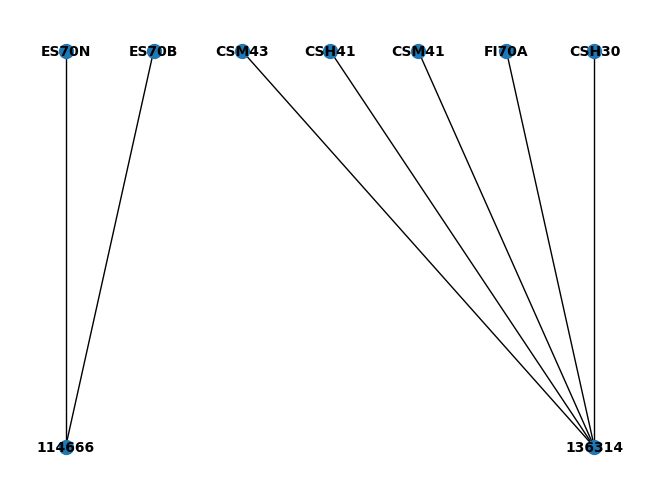

In [70]:
pos = nx.bipartite_layout(G, subset.ID_ANONIMO.unique(), align='horizontal')
nx.draw(G, pos, with_labels=True,  font_size=10, font_weight='bold', node_size=100)
#edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.show()

In [73]:
dados['todos'][dados['todos']['ID_ANONIMO'] == 114666]

,ID_ANONIMO,CR,PERIODO,INGRESSO,CODIGO,ANO,PERIODO.1,NOTA,CH,SITUACAOALUNO
11646,114666.0,0.7928,10,09/08/10,IF66B,2013.0,1.0,0.0,60.0,Formado
11647,114666.0,0.7928,10,09/08/10,ES61A,2010.0,2.0,9.0,30.0,Formado
11648,114666.0,0.7928,10,09/08/10,EL68F,2015.0,1.0,7.0,60.0,Formado
11649,114666.0,0.7928,10,09/08/10,IF62J,2011.0,1.0,8.0,45.0,Formado
11650,114666.0,0.7928,10,09/08/10,IF66B,2014.0,2.0,7.3,60.0,Formado
...,...,...,...,...,...,...,...,...,...,...
11728,114666.0,0.7928,10,09/08/10,IF63C,2011.0,2.0,7.4,45.0,Formado
11729,114666.0,0.7928,10,09/08/10,IF63F,2011.0,2.0,8.2,60.0,Formado
11730,114666.0,0.7928,10,09/08/10,ENADE I,2011.0,1.0,0.0,0.0,Formado
11731,114666.0,0.7928,10,09/08/10,ES60B,2016.0,1.0,8.5,30.0,Formado


In [72]:
dados['todos'][dados['todos']['ID_ANONIMO'] == 179406]

,ID_ANONIMO,CR,PERIODO,INGRESSO,CODIGO,ANO,PERIODO.1,NOTA,CH,SITUACAOALUNO
21383,179406.0,0.0,1,29/02/16,IF61B,2016.0,1.0,0.0,60.0,Desistente
21384,179406.0,0.0,1,29/02/16,IF61C,2016.0,1.0,0.0,90.0,Desistente
21385,179406.0,0.0,1,29/02/16,ES70R,2016.0,1.0,0.0,30.0,Desistente
21386,179406.0,0.0,1,29/02/16,FI71M,2016.0,1.0,0.0,60.0,Desistente
21387,179406.0,0.0,1,29/02/16,MA71A,2016.0,1.0,0.0,90.0,Desistente
21388,179406.0,0.0,1,29/02/16,MA71B,2016.0,1.0,0.0,90.0,Desistente
